In [9]:
import datetime
import torch
import gan
import shutil
from synth_data_source import loadData

We are going to start by preparing our various models. First we will start with the model described in our target paper "Desmoking Laparoscopy Surgery Images Using an Image-to-Image Translation Guided by an Embedded Dark Channel"
We will have to define a discriminator and a generator. Note the tables here reflect processing a 512x512 image as opposed to 256x256 as the original paper used. Also note that upon inspecting the paper repository, the tables in the paper appear inaccurate. I recreated these nets to be true to their repository by looking at the logic that generates the nets used.

Since the arguments used were not specified in the paper I made a best estimate related to optional arguments based on what I thought would make sense. I also made some modification on where I apply dropout based on some advice from Dr. Florian Richter. It appears dropout was applied on all the 'decoder' layers in the unet, but it equally well could have not been applied at all depending on arguments passed at runtime. My assumption is dropout will be helpful and should be applied at the innermost layers of the decoder.

<center>

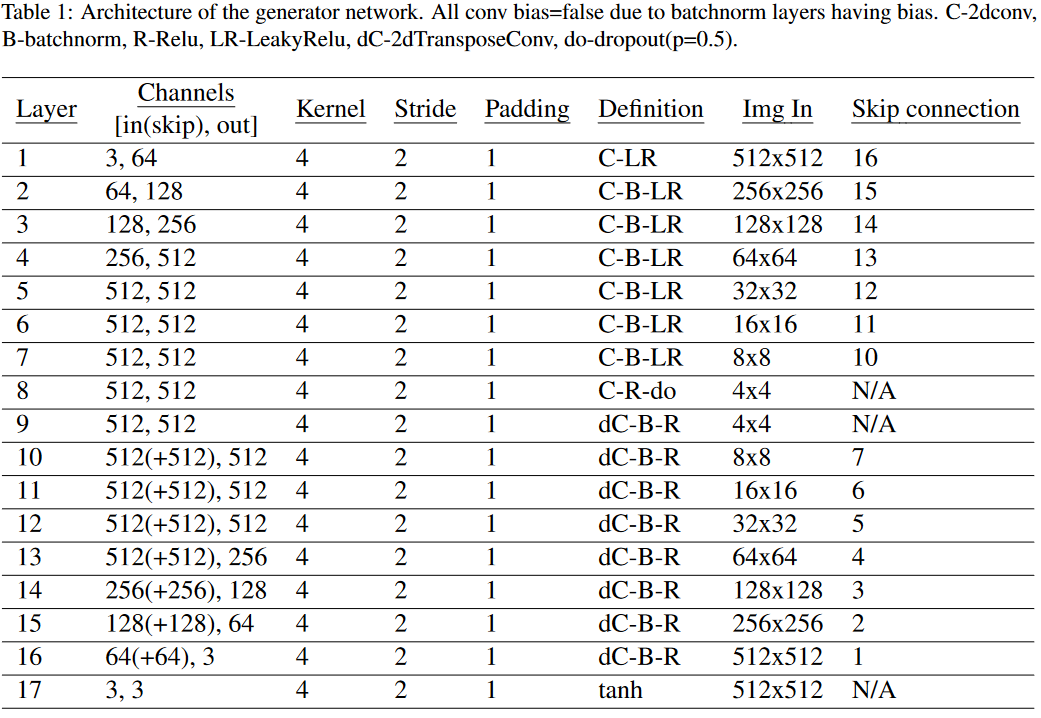

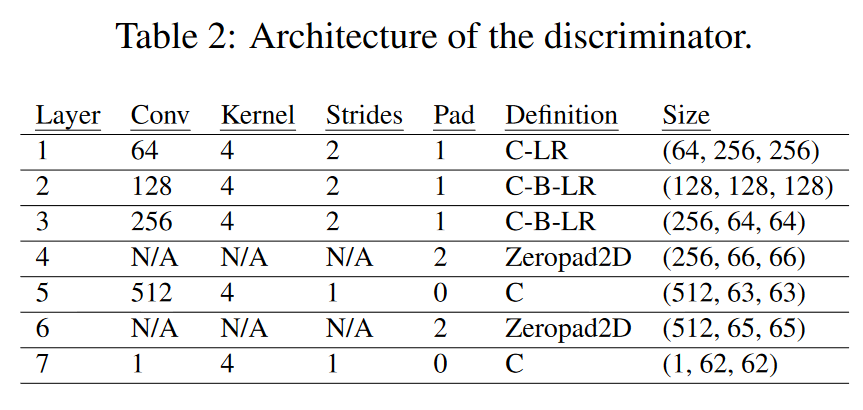

</center>

I am only showing this discriminator code here. Please see models.py for all the models we will be using. They take up a lot of screen space since I wrote them out explicitly.

In [10]:
# DEFINE THE PAPER DISCRIMINATOR
class Discriminator_demo(torch.nn.Module):
    def __init__(self, input_channels:int = 3):
        super().__init__()

        self.sequence = [torch.nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1), 
                    torch.nn.LeakyReLU(0.2, True)]
        
        sequence += [torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), 
                     torch.nn.BatchNorm2d(128),
                     torch.nn.LeakyReLU(0.2, True)]
        
        sequence += [torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), 
                     torch.nn.BatchNorm2d(256),
                     torch.nn.LeakyReLU(0.2, True)]
        
        sequence += [torch.nn.ZeroPad2d(2)]
        
        sequence += [torch.nn.Conv2d(256, 512, kernel_size=4, stride=1), 
                     torch.nn.BatchNorm2d(512),
                     torch.nn.LeakyReLU(0.2, True)]
        
        sequence += [torch.nn.ZeroPad2d(2)]
        
        sequence += [torch.nn.Conv2d(512, 1, kernel_size=4, stride=1)]
        
        self.model = torch.nn.Sequential(*sequence)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.model(x)



Now we import models. Note that UNET is the paper implementation and UNETsmolr is the ablated version with layers 6, 7, 10, and 11 taken out. Please do not reference the code and the numbers to the right of the layers. These layers have different assigned numbers than how it is organized in the report. In the code every individual nn.module has its own layer number instead of being grouped together in larger 'layers' as in the report. The layer numbers given are per the report layer numbering. Please see models.py for implementation details on exactly where the skip connections are and how everything is hooked up.

In [11]:
import models

Note our trainer is located in gan.py. You will want to reference that file along with the inherited class from data_augmentation in order to understand the training, validation and testing. I have included it instead of implementing it here to reduce the length of this notebook.

You will also want to reference losses.py for PSNR and other metrics being taken for image quality. UQI specifically is patched in torchmetrics library below. Please see 'patch' folder for uqi.py and distributed.py which have been modified for numerical stability. Original implementation resulted in inf, -inf, and NaN which are not valid outputs for UQI who's range is -1 to 1. I have included commented out code in uqi.py which can help you print out the values needed in order to understand the source of instability in the caluculation. It is mostly a result of divising by zero resulting in -inf, inf and 0/0 which results in NaN for torch.tensor types.

The following block patched your torchmetrics library this these changes. DO NOT RUN THIS ON ANY ENVIRONMENT USED FOR ANY PURPOSE OUTSIDE OF RUNNING THIS REPOSITORY. The patches are not safe to use outside of this particular application.

Note: If your python env is not run with appropriate permissions, or the folder containing your python env is set to read-only this will fail. You can alternatively copy and paste the files as follows manually and skip this box:

envs\DL4H_CS598_2\Lib\site-packages\torchmetrics\utilities   <-   distributed.py

envs\DL4H_CS598_2\Lib\site-packages\torchmetrics\functional\image   <-   uqi.py

In [12]:
import torchmetrics
bpath = torchmetrics.__path__[0]
bpath + '/utilities/'
shutil.copyfile('patches/distributed.py', bpath + '/utilities/distributed.py')
shutil.copyfile('patches/uqi.py', bpath + '/functional/image/uqi.py')

'c:\\Users\\Karol\\.conda\\envs\\DL4H_CS598_2\\lib\\site-packages\\torchmetrics/functional/image/uqi.py'

Now we will setup some arguments which we will use to run our trainer.

In [13]:
args_data = {
        'pre_path' : 'C:/Users/Karol/Documents/DL4H',
        'cache_subfolder' : '/datasets/cholec80/cache',
        'cache_subfolder_test' : '/datasets/cholec80/cache_testset',
        'syn_smoke_subfolder' : '/datasets/cholec80/synthetic_smoke/',
        'dataset_subfolder' : '/datasets/cholec80/input_formatted',
        'dataset_subfolder_test' : '/datasets/cholec80/input_formatted_test'
}

run_folder_path = args_data['pre_path'] + '/runs'

args = {      
        'save' : run_folder_path+'/{}'.format(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')),
        'batch' : 8,
        'lr' : 0.0002,
        'epochs' : 60,
        'gpu' : 0,
        'use_dark_channel' : False,
        'load_net' : None,
        'run_val_and_test_every_steps' : 1718
}

Now we will start tensorboard. This will allow us to view our model train and look at all the losses as well as output images on validatoin and testing steps.

In [14]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Running the next line twice may be necessary if you want to see tensorboard in this notebook. Alternatively scroll down for a link to open in your browser. Note that if this step takes 0.0s try changing the port as it did not actually launch tensorboard. Alternatively this can also happen as a result of tensorboard already running. If you have launched it once before from this notebook it is likely already running.

PLEASE UPDATE THE BELOW WITH THE CORRECT PATH TO YOUR 'RUNS' DIRECTORY!!!

In [16]:

%tensorboard --logdir $run_folder_path --port 6006 --host localhost

Great, now open tensorboard here: http://localhost:6006

Lets load all our data in.

In [16]:
train_data, val_data, test_data = loadData(args_data)

CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 43325 but video length is 43326. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video01\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 70975 but video length is 70976. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video02\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 145700 but video length is 145701. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video03\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 38050 but video length is 38051. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video04\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 58600 but video length is 58601. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video05\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 53825 but video length is 53826. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video06\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 113925 but video length is 113926. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video07\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 37975 but video length is 37976. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video08\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 67550 but video length is 67551. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video09\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 43725 but video length is 43726. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video10\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 80500 but video length is 80501. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video11\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 27250 but video length is 27251. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video12\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 24525 but video length is 24526. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video13\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 42700 but video length is 42701. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video14\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 51450 but video length is 51451. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video15\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 73925 but video length is 73926. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video16\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 32600 but video length is 32601. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video17\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 48550 but video length is 48551. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video18\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 60600 but video length is 60601. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video19\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 36225 but video length is 36226. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video20\quality_metrics.csv.


NUM ROWS IN CSV WRONG
43326
43325
70976
70975
145701
145700
38051
38050
58601
58600
53826
53825
113926
113925
37976
37975
67551
67550
43726
43725
80501
80500
27251
27250
24526
24525
42701
42700
51451
51450
73926
73925
32601
32600
48551
48550
60601
60600
36226
36225
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 31450 but video length is 31451. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted_test\video21\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 38300 but video length is 38301. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted_test\video22\quality_metrics.csv.


NUM ROWS IN CSV WRONG
31451
31450
38301
38300


Now we setup our models and run our GAN trainer! This will train and output to tensorboard as it trains. Please set 'save' appropriately in args for log and tensorboard. This step is super easy.

For the inner workings please reference models.py for models and gan.py for the trainer.
The trainer also uses SynthTrainer.py and Trainer.py from the data_augmentation folder.

Most of the basic training is done in gan.py however lots of logging of metrics occurs in SynthTrainer.py

Trainer.py contains framework code to generically train various implementations of SynthTrainer. For the purpose of this project its best to mainly stick to gan.py for intuition on the actual models.

In [17]:
myUNET = models.UNETsmolr()
myDisc = models.Discriminator()

Lets take a look at our UNET. Here we can see all ther paramters and by extension, the layers of the net.

In [18]:
myUNET.parameters

<bound method Module.parameters of UNETsmolr(
  (drp): Dropout(p=0.5, inplace=False)
  (sequence): ParameterList(
      (0): Object of type: Conv2d
      (1): Object of type: LeakyReLU
      (2): Object of type: Conv2d
      (3): Object of type: BatchNorm2d
      (4): Object of type: LeakyReLU
      (5): Object of type: Conv2d
      (6): Object of type: BatchNorm2d
      (7): Object of type: LeakyReLU
      (8): Object of type: Conv2d
      (9): Object of type: BatchNorm2d
      (10): Object of type: LeakyReLU
      (11): Object of type: Conv2d
      (12): Object of type: BatchNorm2d
      (13): Object of type: LeakyReLU
      (14): Object of type: Conv2d
      (15): Object of type: BatchNorm2d
      (16): Object of type: LeakyReLU
      (17): Object of type: Conv2d
      (18): Object of type: BatchNorm2d
      (19): Object of type: LeakyReLU
      (20): Object of type: Conv2d
      (21): Object of type: ReLU
      (22): Object of type: ConvTranspose2d
      (23): Object of type: Batch

Now we run training, validation, and test for our firs scenario. This is the ablated UNET and no dark channel. On a 3070+5800x3d this took 8.5 hours. Expect up to 12 hours for the dark channel models to train. Expected time for validation and testing steps is usually around 20 seconds for each. Note that some time is lost in between when switching between training, validation, and testing which will add a bit to the total execution time. You could improve total time by increasing the 'run_val_and_test_every_steps' argument which controls how many batches are processed before running validation and test.

Expected runtime: 520 minutes

Expected time per epoch: 8 minutes

Expected system memory usage:

Expected vram usage:

In [19]:
#CODE TO TRAIN SCENARIO 1
args['save'] = 'C:/Users/Karol/Documents/DL4H/runs/smol_nodark_60ep{}'.format(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
gan.run(args, myUNET, myDisc, train_data, val_data, test_data)

Epoch 1/60:  50%|█████     | 13752/27461 [04:21<03:36, 63.26batch/s]c:\Users\Karol\.conda\envs\DL4H_CS598_2\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Running Test: 100%|██████████| 290/290 [00:21<00:00, 13.74batch/s]
Epoch 1/60: 27464batch [08:34, 53.34batch/s]                          
Running Test: 100%|██████████| 290/290 [00:21<00:00, 13.45batch/s]
Epoch 2/60: 27464batch [08:13, 55.61batch/s]                          
Running Test: 100%|██████████| 290/290 [00:21<00:00, 13.56batch/s]
Epoch 3/60: 27464batch [08:13, 55.69batch/s]                          
Running Test: 100%|██████████| 290/290 [00:21<00:00, 13.76batch/s]
Epoch 4/60: 27464batch [08:12, 55.74batch/s]                          
Running Test: 100%|█

Run training, validation, and test for scenario 2. This is full u-net and no dark channel.

Expected runtime: 575 minutes

Expected time per epoch: 8 minutes 40 seconds

Expected system memory usage:

Expected vram usage:

In [20]:
#CODE TO TRAIN SCENARIO 2
myUNET2 = models.UNET()
myDisc2 = models.Discriminator()
args['save'] = 'C:/Users/Karol/Documents/DL4H/runs/full_nodark_60ep{}'.format(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
gan.run(args, myUNET2, myDisc2, train_data, val_data, test_data)


Running Test: 100%|██████████| 290/290 [00:22<00:00, 13.07batch/s]
Epoch 1/60: 27464batch [09:26, 48.44batch/s]                          
Running Test: 100%|██████████| 290/290 [00:22<00:00, 13.16batch/s]
Epoch 2/60: 27464batch [09:46, 46.79batch/s]                          
Running Test: 100%|██████████| 290/290 [00:21<00:00, 13.71batch/s]
Epoch 3/60: 27464batch [09:28, 48.34batch/s]                          
Running Test: 100%|██████████| 290/290 [00:22<00:00, 12.76batch/s]
Epoch 4/60: 27464batch [09:57, 45.98batch/s]                          
Running Test: 100%|██████████| 290/290 [00:21<00:00, 13.37batch/s]
Epoch 5/60: 27464batch [09:11, 49.76batch/s]                          
Running Test: 100%|██████████| 290/290 [00:21<00:00, 13.38batch/s]
Epoch 6/60: 27464batch [09:08, 50.06batch/s]                          
Running Test: 100%|██████████| 290/290 [00:21<00:00, 13.72batch/s]
Epoch 7/60: 27464batch [08:48, 51.95batch/s]                          
Running Test: 100%|██████████| 290

Run training, validation, and test for scenario 3. This is ablated u-net and dark channel.

Expected runtime: 644 minutes

Expected time per epoch: 9 minutes 50 seconds

Expected system memory usage:

Expected vram usage:

In [21]:
#CODE TO TRAIN SCENARIO 3
myUNET3 = models.UNETsmolr(input_channels=4)
myDisc3 = models.Discriminator()
args['save'] = 'C:/Users/Karol/Documents/DL4H/runs/smol_dark_60ep{}'.format(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
args['use_dark_channel'] = True
gan.run(args, myUNET3, myDisc3, train_data, val_data, test_data)

Running Test: 100%|██████████| 290/290 [00:22<00:00, 12.70batch/s]
Epoch 1/60: 27464batch [09:55, 46.12batch/s]                          
Running Test: 100%|██████████| 290/290 [00:23<00:00, 12.17batch/s]
Epoch 2/60: 27464batch [09:54, 46.18batch/s]                          
Running Test: 100%|██████████| 290/290 [00:23<00:00, 12.25batch/s]
Epoch 3/60: 27464batch [09:54, 46.22batch/s]                          
Running Test: 100%|██████████| 290/290 [00:23<00:00, 12.25batch/s]
Epoch 4/60: 27464batch [09:54, 46.21batch/s]                          
Running Test: 100%|██████████| 290/290 [00:23<00:00, 12.39batch/s]
Epoch 5/60: 27464batch [09:53, 46.27batch/s]                          
Running Test: 100%|██████████| 290/290 [00:24<00:00, 11.96batch/s]
Epoch 6/60: 27464batch [09:54, 46.17batch/s]                          
Running Test: 100%|██████████| 290/290 [00:23<00:00, 12.17batch/s]
Epoch 7/60: 27464batch [09:54, 46.23batch/s]                          
Running Test: 100%|██████████| 290

Run training, validation, and test for scenario 4. This is full u-net and dark channel.

Expected runtime: 680 minutes

Expected time per epoch: 10 minutes 40 seconds

Expected system memory usage:

Expected vram usage:

In [22]:
importlib.reload(gan)
#CODE TO TRAIN SCENARIO 4
myUNET4 = models.UNET(input_channels=4)
myDisc4 = models.Discriminator()
args['save'] = 'C:/Users/Karol/Documents/DL4H/runs/full_dark_60ep{}'.format(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
args['use_dark_channel'] = True
gan.run(args, myUNET4, myDisc4, train_data, val_data, test_data)

Running Test: 100%|██████████| 290/290 [00:23<00:00, 12.28batch/s]
Epoch 1/60: 27464batch [10:34, 43.29batch/s]                          
Running Test: 100%|██████████| 290/290 [00:22<00:00, 12.65batch/s]
Epoch 2/60: 27464batch [10:33, 43.34batch/s]                          
Running Test: 100%|██████████| 290/290 [00:23<00:00, 12.28batch/s]
Epoch 3/60: 27464batch [10:34, 43.27batch/s]                          
Running Test: 100%|██████████| 290/290 [00:23<00:00, 12.48batch/s]
Epoch 4/60: 27464batch [10:34, 43.27batch/s]                          
Running Test: 100%|██████████| 290/290 [00:23<00:00, 12.33batch/s]
Epoch 5/60: 27464batch [10:34, 43.29batch/s]                          
Running Test: 100%|██████████| 290/290 [00:23<00:00, 12.49batch/s]
Epoch 6/60: 27464batch [10:34, 43.29batch/s]                          
Running Test: 100%|██████████| 290/290 [00:23<00:00, 12.50batch/s]
Epoch 7/60: 27464batch [10:34, 43.28batch/s]                          
Running Test: 100%|██████████| 290

We are now done runing our models. Taking a look at tensorboard we can make a few interesting observations. First let us run through all the metrics and images available to us in tensorboard so we understand what is being shown:

Anything starting with 'Synthetic:' is from the validation step. Anything starting with 'TEST:' is from the testing step. Additionall 'epoc_test' and 'epoch_val' are also respective despite showing effectively the same values. Then 'training loss' and 'training loss: d' are the training loss of the generator and discriminator respectively.


Now we will discuss the image data. This can be found either in the TIME SERIES or IMAGES tab at the top of your tensorboard page:

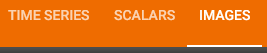

Here we can find for both test and validation sets the following: 

'Composed Img' - This is the composed image containing both the synthetic smoke and background image from the dataset.

'Dark Channel Mask' - This may not be present if the model is run without dark channel prior. However if it is, then it is showing the dark channel as a black and white mask. This should appear similar to the synthetic smoke, although it does not always.

'Predicted Desmoked' - This is the 'Composed Img' once it is run through our generator (conditionally with out dark channel).

'Smoke Mask' - This is the synthetic smoke generated in the synthetic_smoke_prep.ipynb notebook.


Now we will go over the SCALARS that can be found in either the TIME SERIES or SCALARS tab:

First categories:

'Validation Loss - Reference - \<img qual metric\>' - This takes the particular metric listed between the 'Composed Img' and the base truth image from the dataset. It allows us to calculate the image metrics of the images we are trying to improve as a baseline.

'Validation Loss - \<img qual metric\> - This takes the particular metric listed between the 'Predicted Desmoked' and the base truth image from the dataset.

'Validation Loss - Delta - \<img qual metric\>' - This is 'Validation Loss - \<img qual metric\>' minus 'Validation Loss - Reference - \<img qual metric\>' which gives us the 'delta' or improvement in the image metric. This metric is far better for comparing disparate datasets or synthetic smoke sets being appllied. The original paper did not have such a metric making it difficult to figure out how much of their image quality came from minimal distortion on their ground truth images through processing and application of smoke and how much came from their model and methods.


Here we can see that the 'delta' and regulart image quality metrics show that all models performed almost identically with or without dark channel. Seeing as how dark channel is simply picking the lowest intensity channel and using it as a mask, I understand how the model could 'learn' to apply this mask all on its own and why the original author's results could be refuted. The following charts are presented with smoothing at 0.25 in tensorboard.

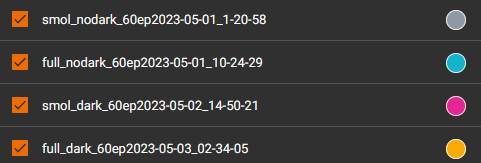

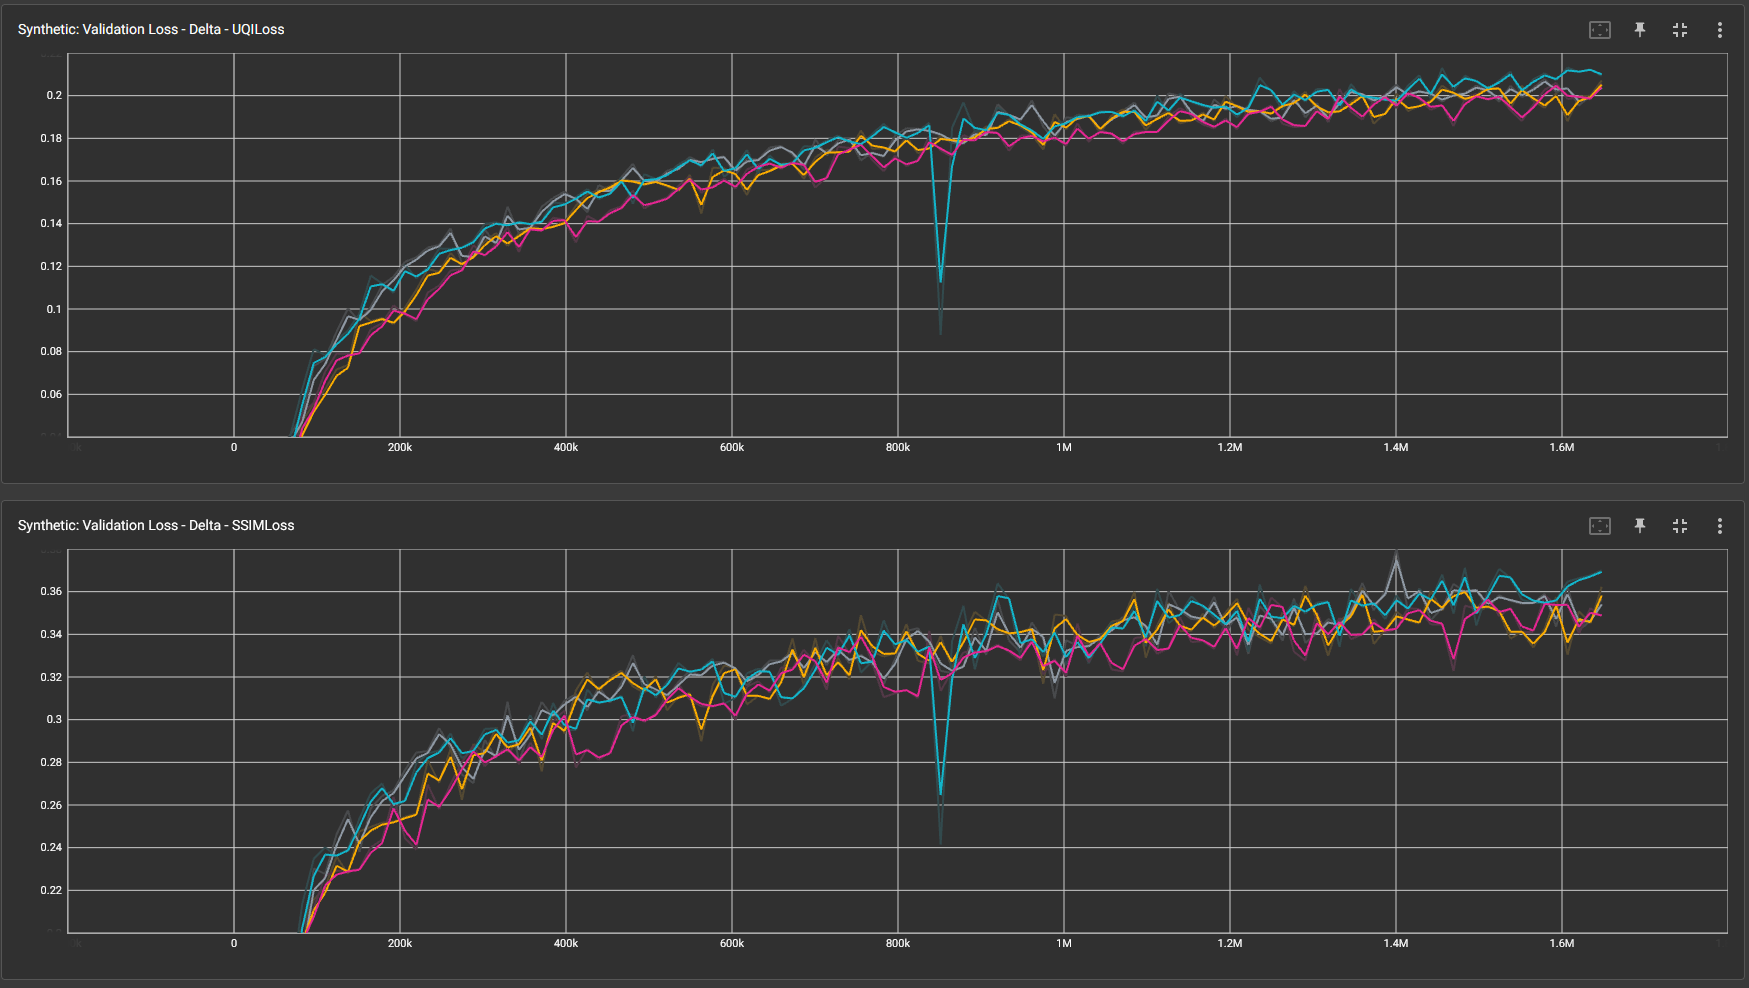

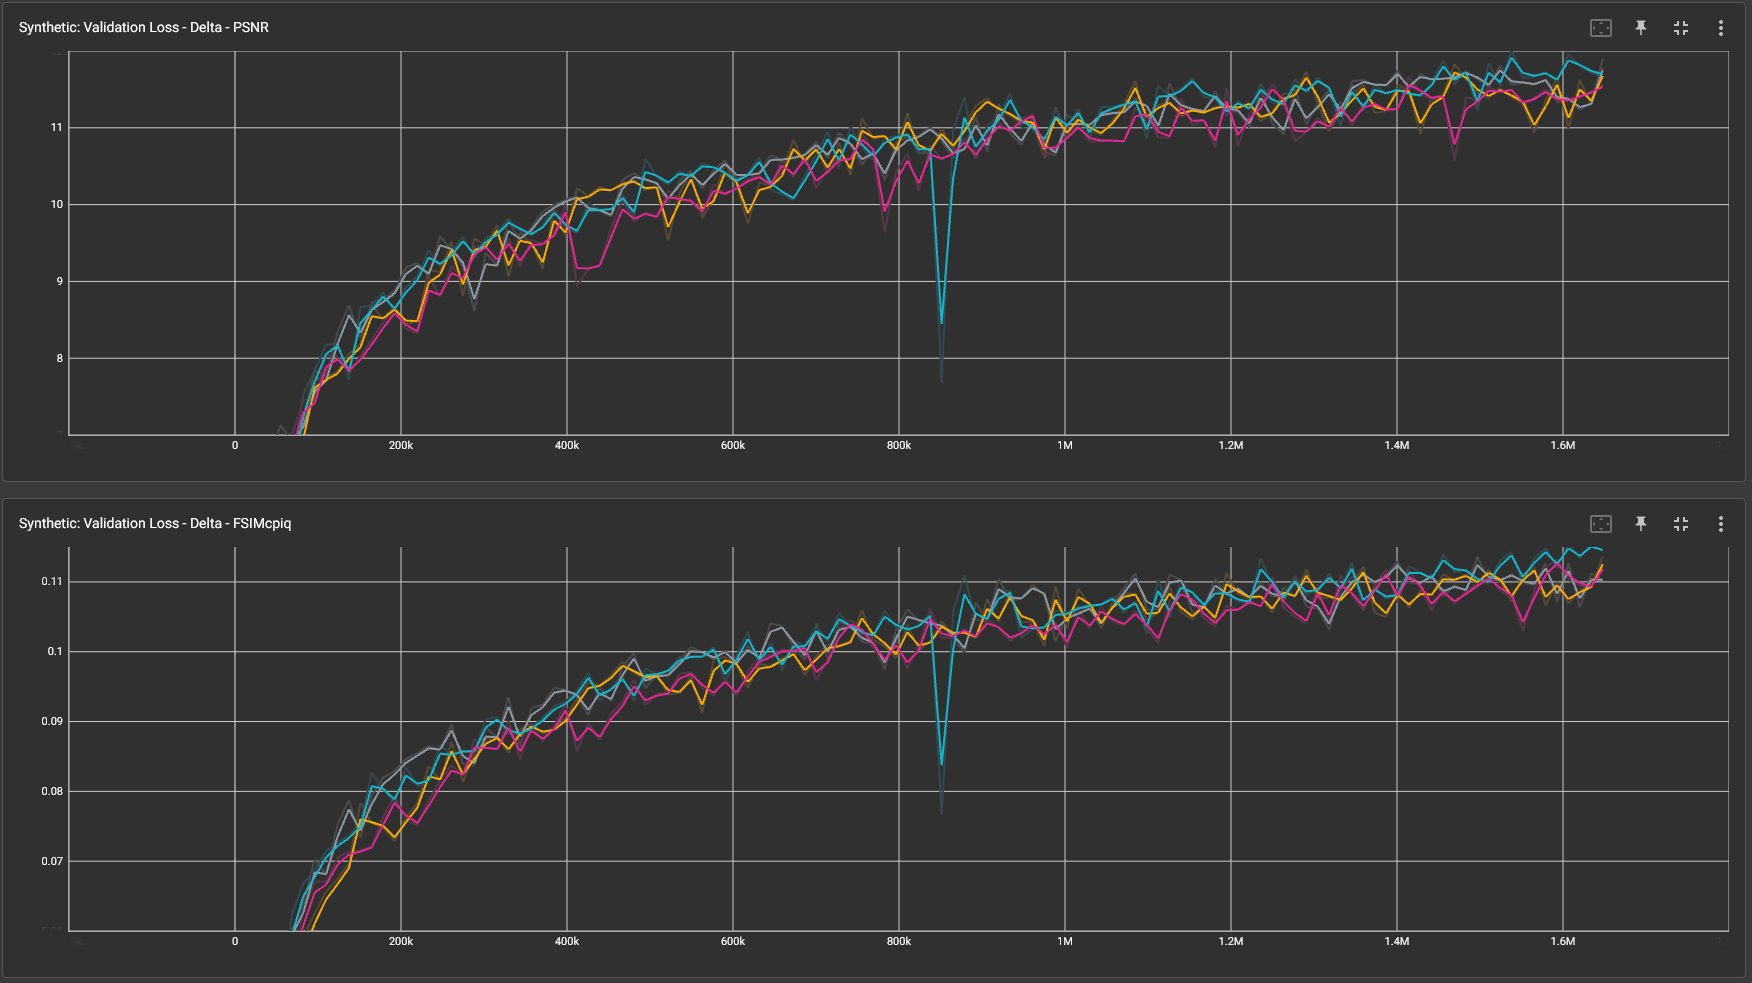

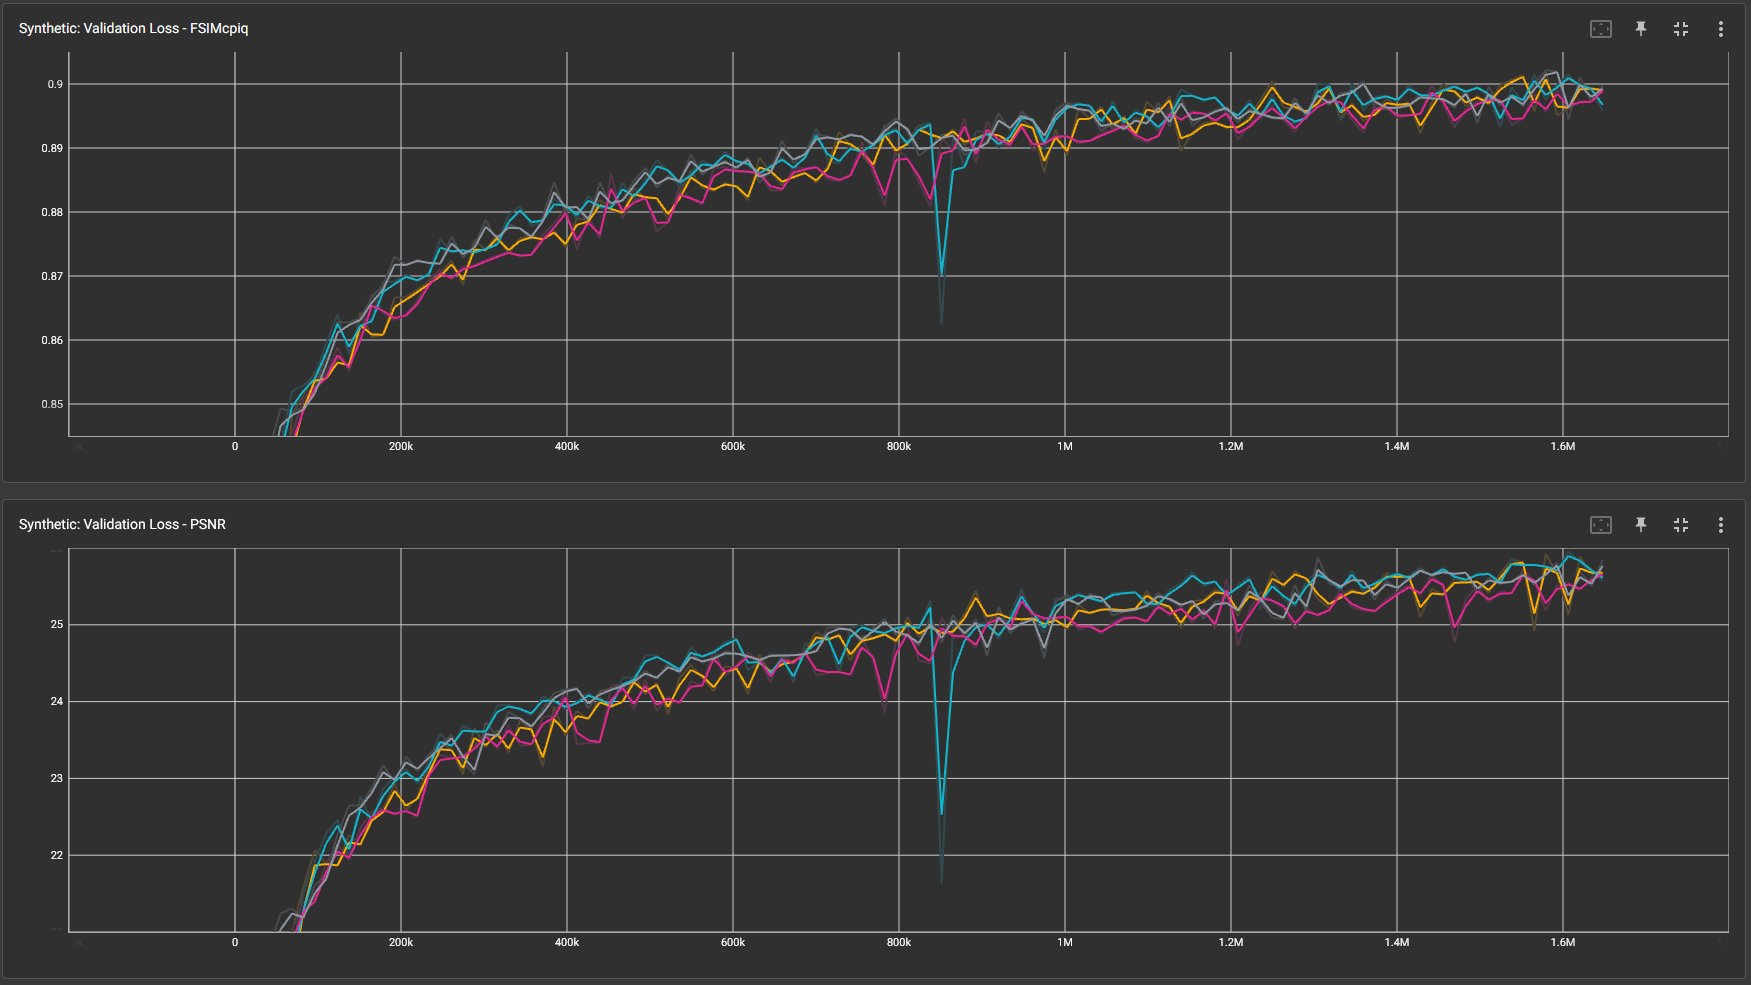

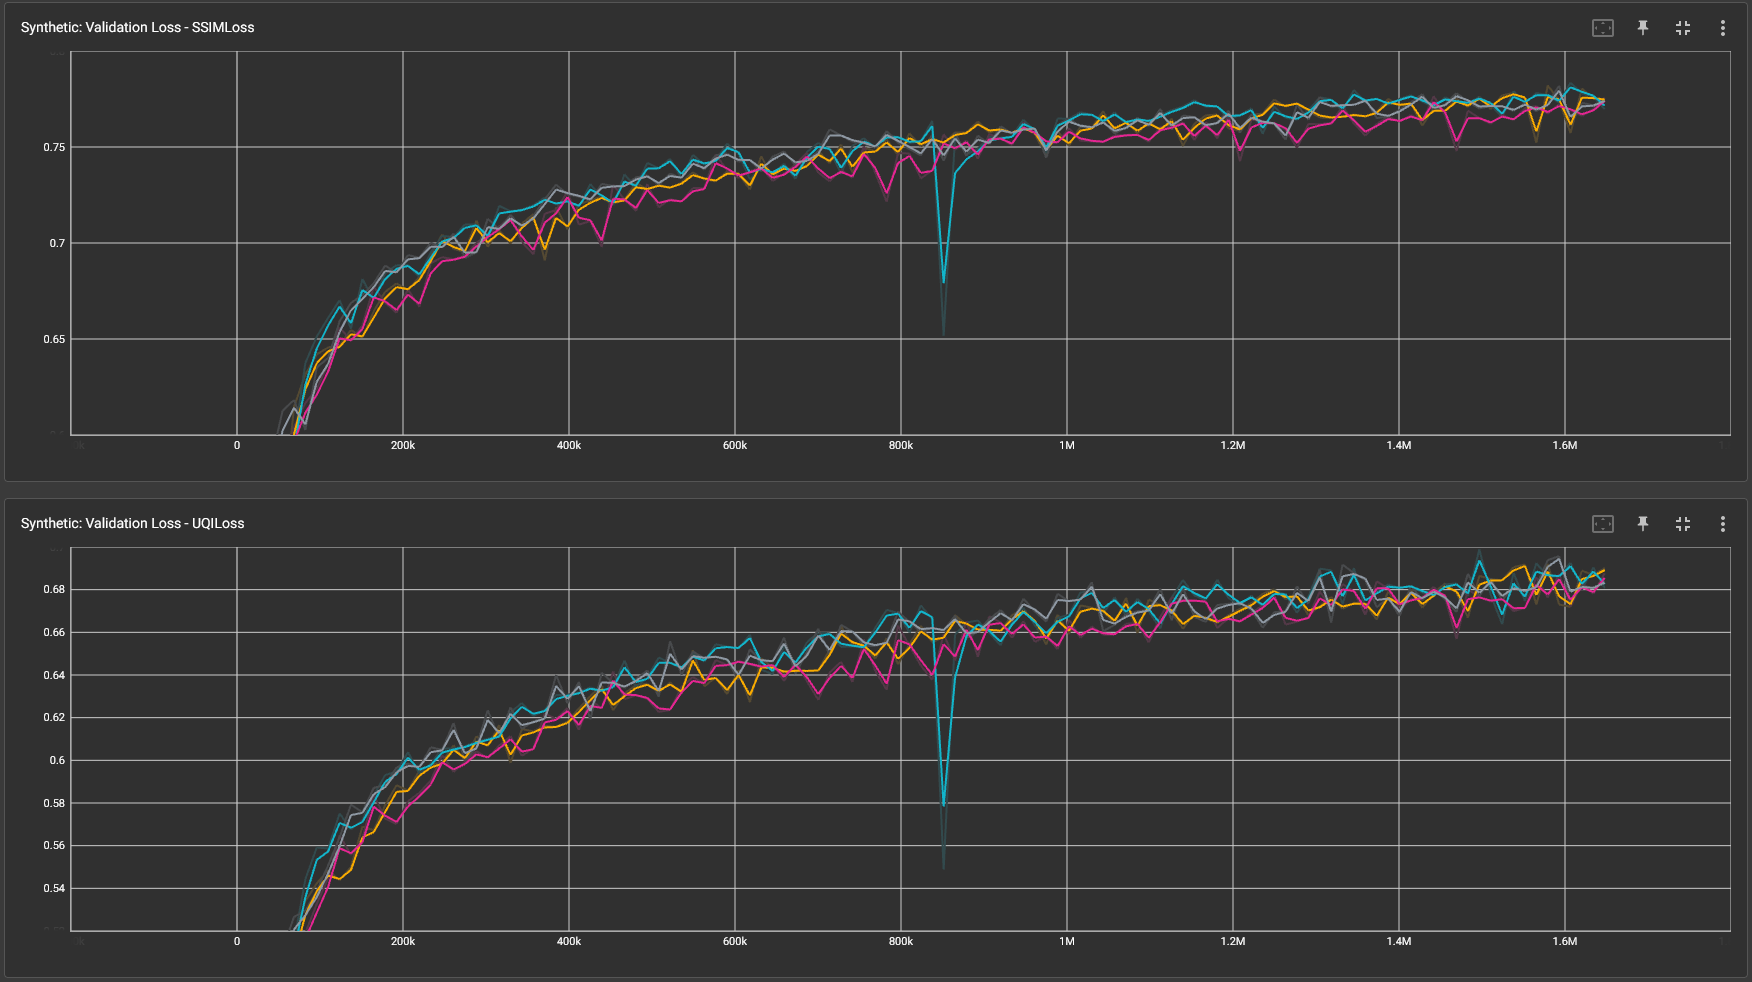

We can also see that for all models performance remains clustered, although at a slightly lower level for all metrics on the test dataset. This makes sense as this would better test the models generalizability which should be poorer than its performance on data related to the training set. It also makes sense that delta is lower. Delta is mostly useful for comparing validation performance across various papers/nets. It should be directly comparable across both test and validation is test and validation sets are chosen in the same way as in this paper. It will however enable us to minimize the roll that additional transforms on input data may have on image quality metrics on output.

Since it is unclear how the source paper created its input dataset we cannot say for certain where the decreased performance is coming from, or if in fact the source paper ever saw higher performance by implementing dark channel at all. Image quality metrics measure distortion in certain features or metrics in the original vs processed image. The metrics after disparate transforms are performed on the image are NOT comparable.

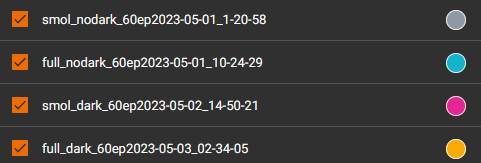

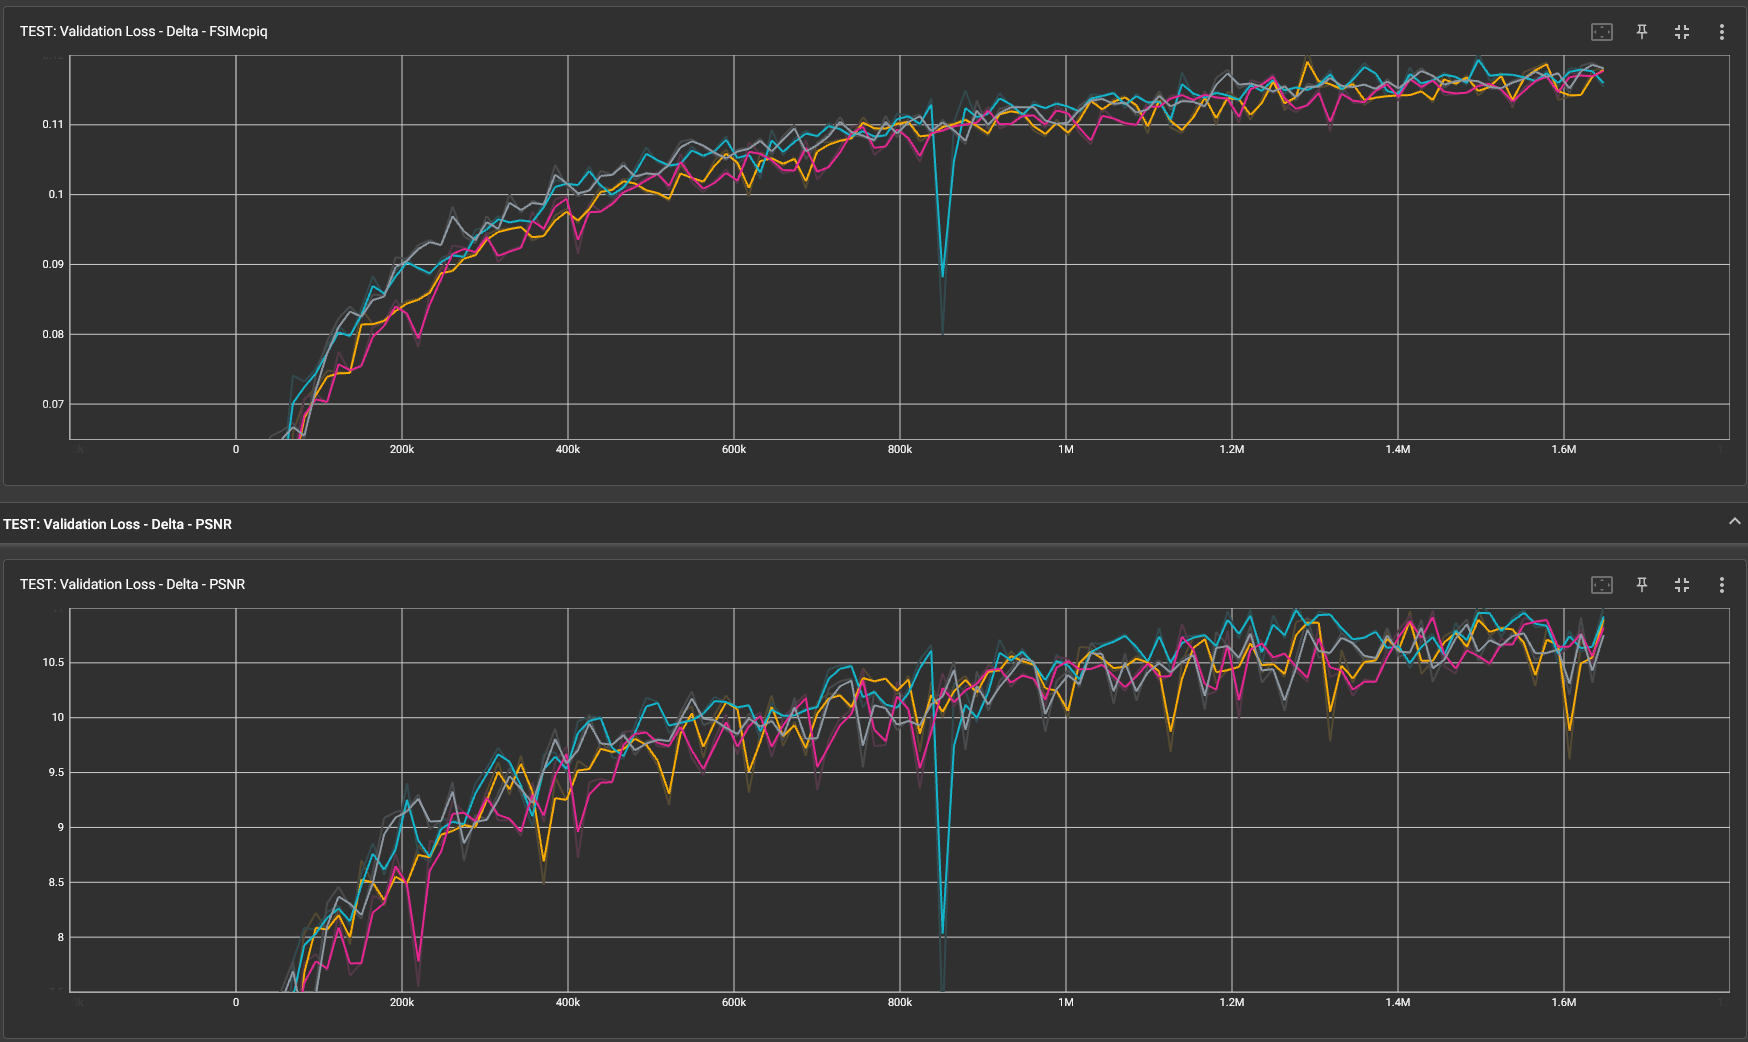

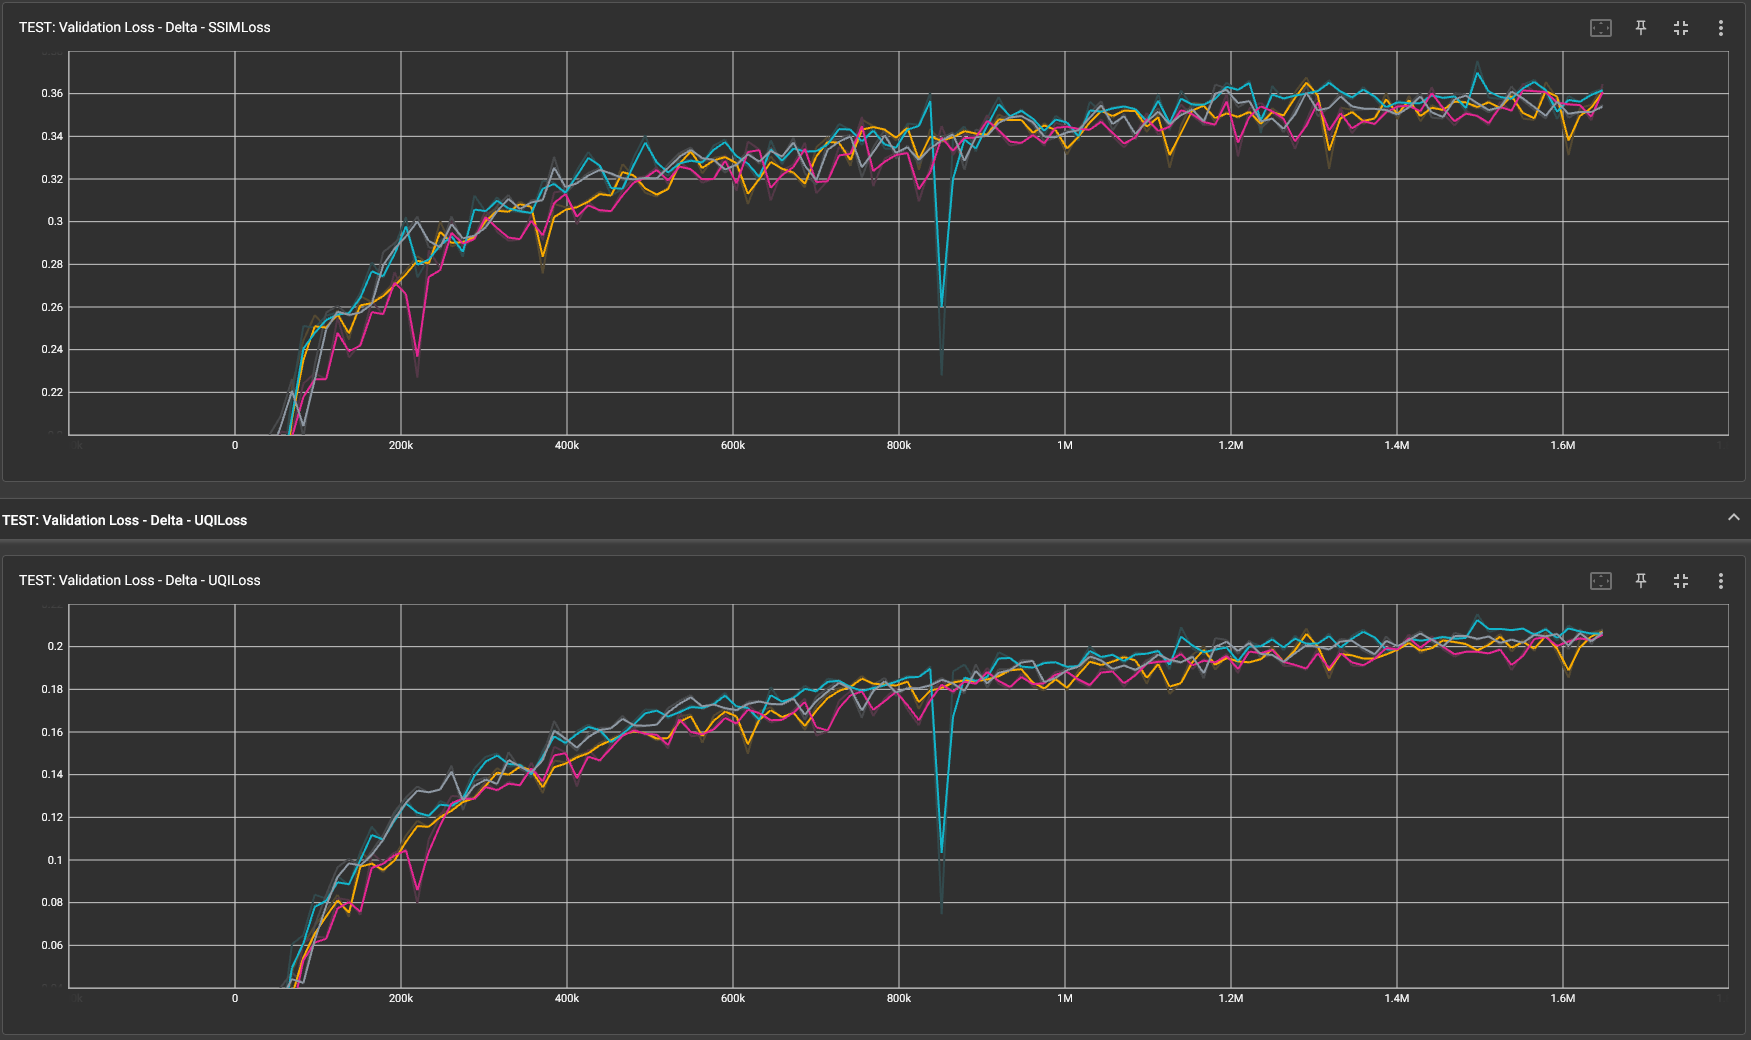

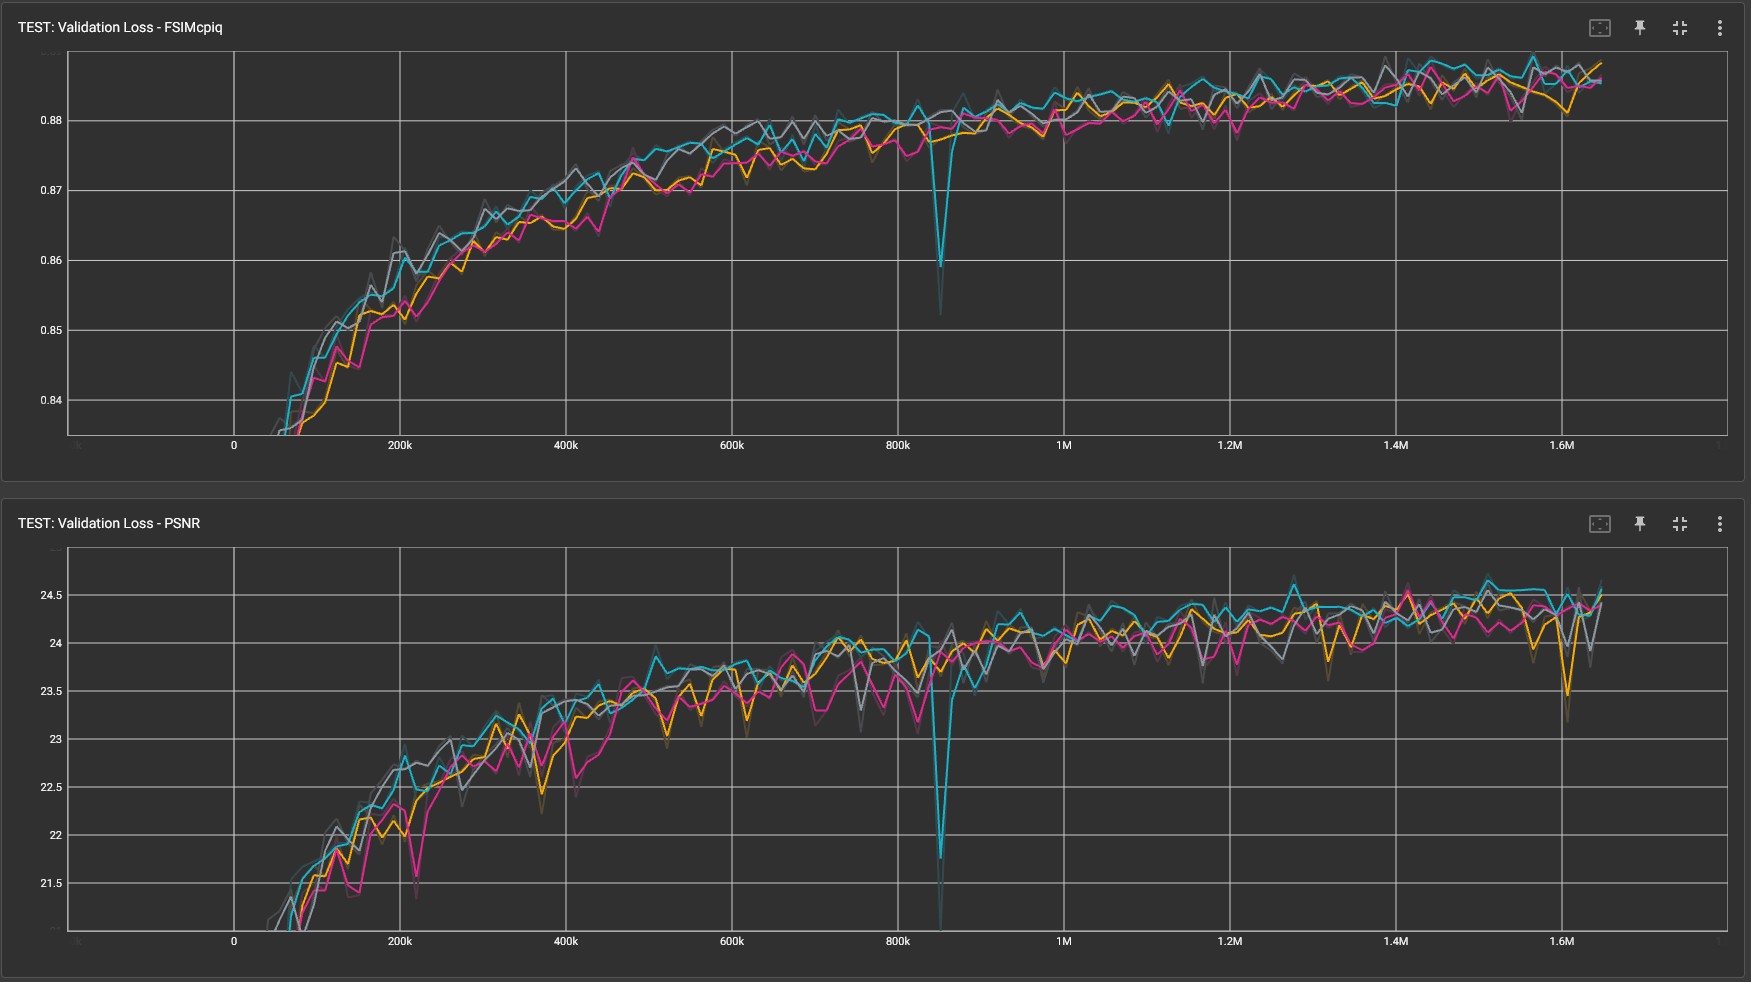

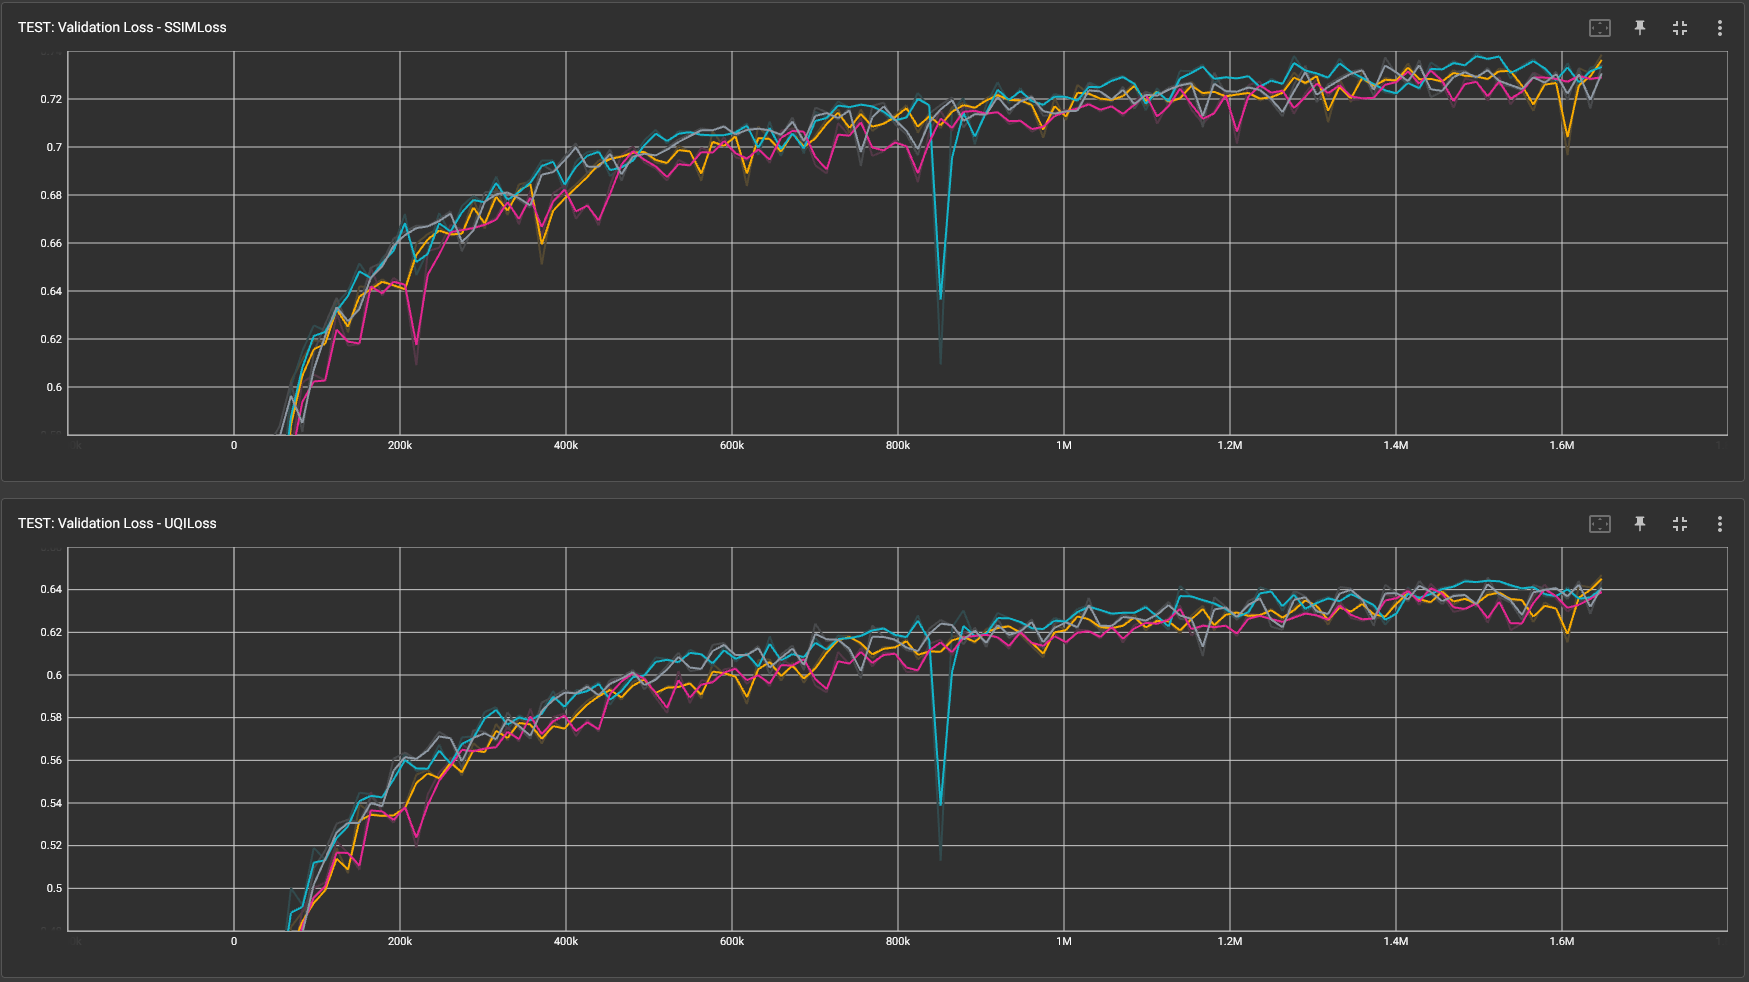

In all cases we see that the leading model is the non-ablated unet with no dark channel. This is counter to the narrative of the paper that dark channel improves performance. There could be other causes to this but even attempting a higher resolution dark channel implementation which can be found in branch 'dcp_alternative' caused even lower image quality metrics on output.

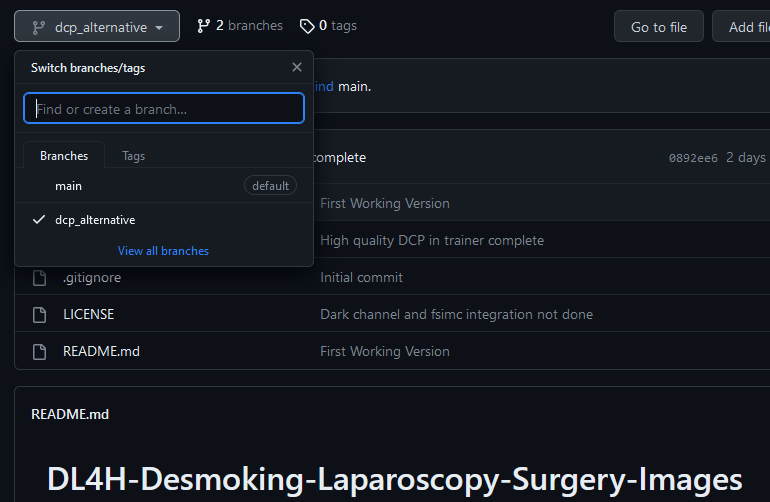

This implementation takes the dark channel of the original composited image before any crop or other transforms are applied. I then applies those transforms to both images in parallel and feeds them into the model for training. The results is the dark channel has less aliasing artifacts. Despite this performance appears to degrade. One theory I have is antialiasing applied at some point by the transformations may in fact be causing divergence between the two images. Since the edges in the original and dark channel images may be drastically different this could result in additional noise the model cannot deal with well.

Additional experimentation and analysis of original author code is needed to understand where else error could be coming from. One possible place could also be the GAN loss function which is not designed the same way between my implementation and the original author's. This could cause the models to put emphasis on features in a slightly different way. In a GAN the balance between discriminator and generator can also have an impact on the model's ability to train. It is possible that the emphasis of the discriminator vs the impact of the original image loss is not significant enough causing the model to try to converge to the base truth but not be impacted by the discriminator as much. This could certainly cause the model to train differently.

In order to avoid this the author may want to specify the loss functions for discriminator and generator in their paper as opposed to their code where it can be impacted by command line arguments. These arguments were likewise not included in the paper. This combined with the missing details on how the training set was created make it impossible to recreate the results in the paper with any certainty.